## Linear Regression Example

Fit in linear regression on a sample dataset.

### Load libraries

In [190]:
import numpy as np
import pandas as pd
from itertools import combinations
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

### Load sample data

`Sample GBP USD FX and UK Inflation data will be sourced`
`This is to investigate whether inflation would have an impact of movements of GBP prices`

In [107]:
fx_data = pd.read_csv(f'..//data//GBPUSD_20130819_20230818.csv', parse_dates=['Date']).set_index('Date')
inf_data = pd.read_csv(f'..//data//UK_inflation_rates_201307_202307.csv', parse_dates=['Date']).set_index('Date')

### Resample and clean up the data

In [149]:
# Resample data to monthly (taking last value)
fx_data_m = fx_data.resample('M').last()
# Add one day to come to the beginning of next month
fx_data_m.index = fx_data_m.index + timedelta(days=1)

In [150]:
# Join both data sets
df = fx_data_m.join(inf_data, how='outer').ffill().dropna()

In [152]:
inflation_cols = ['CPIH', 'CPI', 'OOH']
fx_cols = ['Open', 'High', 'Low', 'Close']
# Shift inflation rates
df[[f'{x}_PREV' for x in inflation_cols]] = df[inflation_cols].shift()
df = df.dropna().sort_index()

## Split data Into Train, Validation and Test

In [153]:
n = len(df.index)

train_n = int(round(n * 0.8 * 0.8, 0))
validation_n = int(round(n * 0.8 * 0.2, 0))
test_n = int(round(n * 0.2, 0))

train_idx = df.index[:train_n]
validation_idx = df.index[train_n:train_n+validation_n]
test_idx = df.index[train_n+validation_n:]

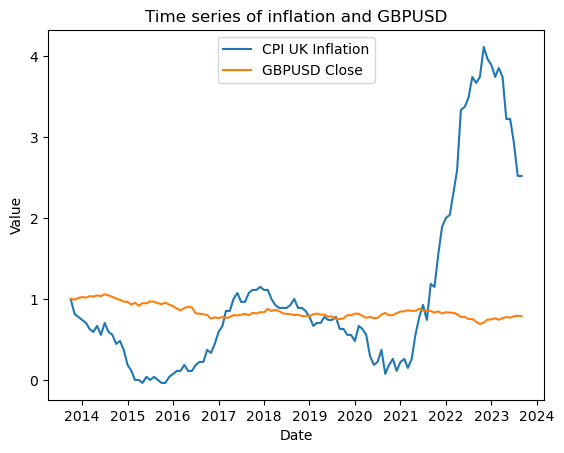

In [132]:
plt.plot(df[['CPI_PREV']] / df[['CPI_PREV']].iloc[0], label='CPI UK Inflation')
plt.plot(df[['Close']] / df[['Close']].iloc[0], label='GBPUSD Close')
plt.ylabel('Value')
plt.xlabel('Date')
leg = plt.legend(loc='upper center')
plt.title('Time series of inflation and GBPUSD')
plt.show()

In [394]:
df.loc[train_idx, ['CPI_PREV', 'Close']].corr()

,CPI_PREV,Close
CPI_PREV,1.000000,-0.373194
Close,-0.373194,1.000000


In [395]:
def calulate_linear_coefficients(df_input, y, xs):
    df = df_input.copy()
    if type(xs) == str:
        xs = [xs]
    xs = ['const'] + xs
    df['const'] = 1
    xs_n = len(xs)
    x_matrix = np.zeros((xs_n,xs_n))
    y_array = np.zeros(xs_n)
    a_matrices = []
    for r in range(xs_n):
        y_array[r] = np.dot(df[y], df[xs[r]])
        for c in range(xs_n):
            if r == 0 and c == 0:
                x_matrix[0,0] = df.shape[0]
            else:
                r_col = xs[r]
                c_col = xs[c]
                x_matrix[r, c] = np.dot(df[r_col], df[c_col])
                
    coefficients = {}
    x_determinant = np.linalg.det(x_matrix)
    for r in range(xs_n):
        a_matrix = x_matrix.copy()
        a_matrix[:, r] = y_array
        coefficients[f'b{r}'] = np.linalg.det(a_matrix) / x_determinant
    return coefficients

In [396]:
coefficients = calulate_linear_coefficients(df.loc[train_idx], 'Close', ['CPI_PREV'])

In [397]:
def predict_linear_reg(df_input, xs, coefficients):
    df_input['y_pred'] = coefficients['b0']
    for i, x in enumerate(xs):
        df_input['y_pred'] = coefficients[f'b{i+1}'] * df_input[x]
    return df_input['y_pred'].values

In [399]:
df.loc[train_idx, 'Close_pred'] = predict_linear_reg(df.loc[train_idx], ['CPI_PREV'], coefficients)

In [400]:
def calculate_R2(df, y, xs):
    xs_n = len(xs)
    n = df.shape[0]
    mean_y = df[y].mean()
    reg_ss = sum((df[y] - mean_y) ** 2)
    res_ss = sum((df[y] - df[f'{y}_pred']) ** 2)
    tot_ss = reg_ss + res_ss
    return {'R2': 1 - res_ss/tot_ss, 'adjR2': 1 - ((res_ss/(n-xs_n)) / (tot_ss/(n-1)))  }

In [401]:
calculate_R2(df.loc[train_idx], 'Close', ['CPI_PREV'])

{'R2': 0.0094007093183609, 'adjR2': 0.0094007093183609}